<a href="https://colab.research.google.com/github/yanncoadou/MLtutorials/blob/main/ML_IDPASC2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>IDPASC 2021 Machine learning hands-on</h1>

# Standard imports and practical functions

In [1]:
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_circles
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay

%matplotlib inline
import seaborn as sns # seaborn for nice plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
np.random.seed(31415) # set the np random seed for reproducibility

### Function to plot decision contours

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def my_plot_decision_regions(model, X, y, alpha=1.0, size=25, npts=10000, zoom=0.25, event5=False):
  x1min = X[:,0].min() - zoom
  x1max = X[:,0].max() + zoom

  x2min = X[:,1].min() - zoom
  x2max = X[:,1].max() + zoom
  
  x1 = np.random.uniform(x1min, x1max, npts)
  x2 = np.random.uniform(x2min, x2max, npts)

  if hasattr(model, "predict_proba"):
    z = model.predict_proba(np.vstack((x1,x2)).T)
  else:
    z = model.predict(np.vstack((x1,x2)).T)
  
  if len(z.shape) == 2:
    if z.shape[1] == 1:
      z = z.reshape(-1)
    elif z.shape[1] == 2:
      z = z[:,1].reshape(-1)

  fig, ax = plt.subplots()

  bottom = cm.get_cmap('Oranges', 128)
  top = cm.get_cmap('Blues_r', 128)

  newcolors = np.vstack((top(np.linspace(0, 1, 128+128)[-128:]),
                        bottom(np.linspace(0, 1, 128+128)[:128])))
  newcmp = ListedColormap(newcolors, name='OrangeBlue')


  ax.tricontour(x1, x2, z, levels=np.linspace(0.0-np.finfo(float).eps,1.0+np.finfo(float).eps,20,True), linewidths=0.1, colors='k', antialiased=True)
  cntr = ax.tricontourf(x1, x2, z, levels=np.linspace(0.0-np.finfo(float).eps,1.0+np.finfo(float).eps,20,True), cmap=newcmp)
  sctr0 = ax.scatter(X[y==0][:,0], X[y==0][:,1], alpha=alpha, s=size, c="#1f77b4", marker="s", edgecolors="k", linewidths=0.5)
  sctr1 = ax.scatter(X[y==1][:,0], X[y==1][:,1], alpha=alpha, s=size, c="#ff7f0e",  marker="^", edgecolors="k", linewidths=0.5)
  if event5: # showing particular swinger event
    sctr2 = ax.scatter(X[4][0], X[4][1], alpha=1, s=size*10, c="lightgreen",  marker="X", edgecolors="k", linewidths=1)
  fig.colorbar(cntr, ax=ax)
  # ax.set(xlim=(x1min, x1max), ylim=(x2min, x2max))

  plt.show()

### Function to plot ROC curve

In [3]:
def my_plot_roc_curve(model, X_test, y_test):
  if hasattr(model, "predict_proba"):
    y_scores = model.predict_proba(X_test)
  else:
    y_scores = model.predict(X_test)

  if len(y_scores.shape) == 2:
    if y_scores.shape[1] == 1:
      y_scores = y_scores.reshape(-1)
    elif y_scores.shape[1] == 2:
      y_scores = y_scores[:,1].reshape(-1)
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  roc_auc = roc_auc_score(y_test, y_scores)
  plt.clf()
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model.__class__.__name__)
  display.plot()
  plt.plot([0, 1], [0, 1], color='black', linestyle='--')
  plt.show()

# Classifier zoo

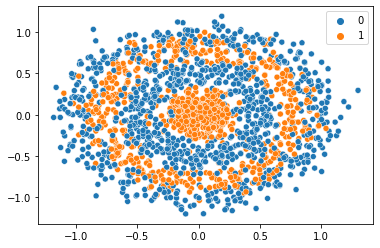

In [4]:
# X = (x,y) coordinates; y = class
X1, y1 = make_circles(n_samples=1000, noise=0.1, factor=0.8)
X2, y2 = make_circles(n_samples=1000, noise=0.2, factor=0.2)
X = np.vstack((X1,X2/2))
y = np.hstack((y1,y2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

### Decision tree

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

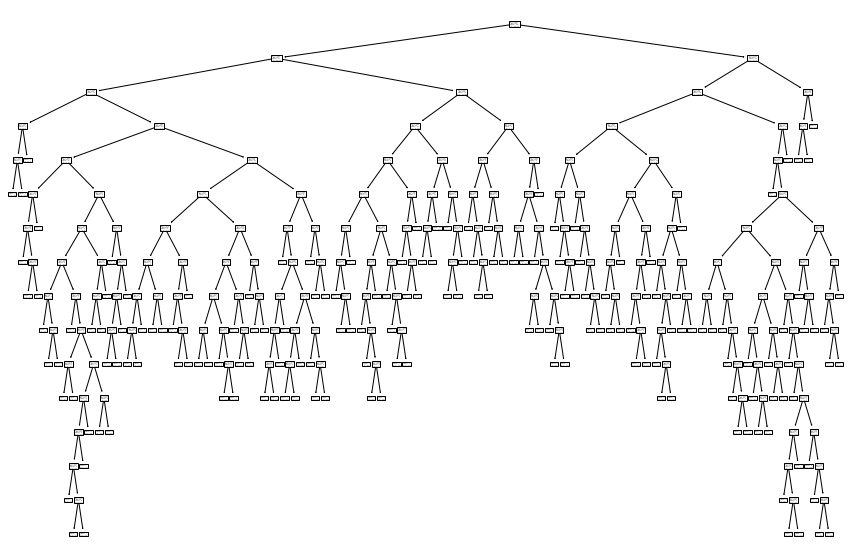

In [7]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,10))
plot_tree(dtc)
plt.show();


In [8]:
accuracy_score(y_test, dtc.predict(X_test))

0.773

Access to results:
- `predict` returns the class (0 or 1 if binary classifier)
- `predict_proba` returns the probability of each class



In [9]:
print("predict: \n",dtc.predict(X_test[:5]))
print("predict_proba: \n",dtc.predict_proba(X_test[:5]))

predict: 
 [1 1 1 0 1]
predict_proba: 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [10]:
try:
  from mlxtend.plotting import plot_decision_regions
except ImportError as e:
  !pip install mlxtend
  from mlxtend.plotting import plot_decision_regions

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


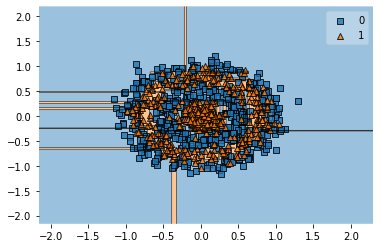

In [11]:
# practical but limited contour-plotting function
plot_decision_regions(X_test, y_test, dtc);

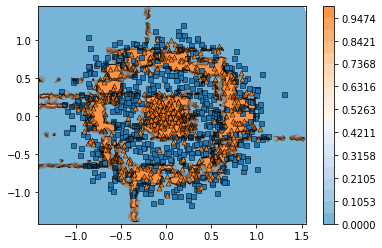

In [12]:
# defined at top of notebook
# can use class (0 or 1) or class probability when available
my_plot_decision_regions(dtc, X_test, y_test)

<Figure size 432x288 with 0 Axes>

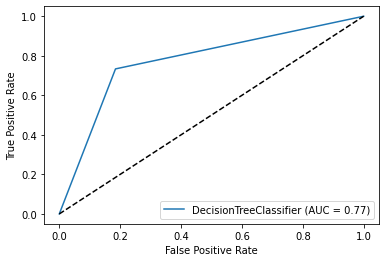

In [13]:
my_plot_roc_curve(dtc, X_test, y_test)

### AdaBoost

In [14]:
from sklearn.ensemble import AdaBoostClassifier

In [15]:
#abc = AdaBoostClassifier()
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),n_estimators=100)
abc.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [16]:
print("predict: \n",abc.predict(X_test[:5]))
print("predict_proba: \n",abc.predict_proba(X_test[:5]))

predict: 
 [1 1 1 0 1]
predict_proba: 
 [[0.18219013 0.81780987]
 [0.2697378  0.7302622 ]
 [0.46794236 0.53205764]
 [0.56211408 0.43788592]
 [0.26346077 0.73653923]]


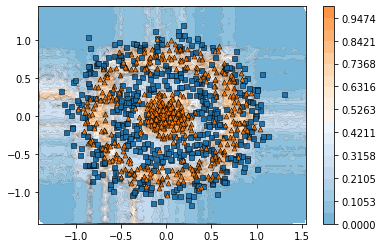

<Figure size 432x288 with 0 Axes>

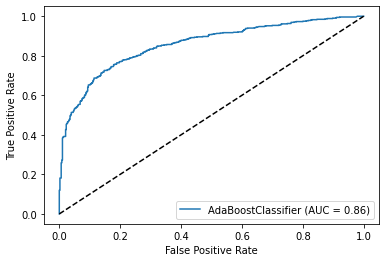

In [17]:
my_plot_decision_regions(abc, X_test, y_test)
my_plot_roc_curve(abc, X_test, y_test)

### Gradient boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
gbc = GradientBoostingClassifier(n_estimators=400)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
print("predict: \n",gbc.predict(X_test[:5]))
print("predict_proba: \n",gbc.predict_proba(X_test[:5]))

predict: 
 [1 1 1 0 0]
predict_proba: 
 [[0.02772398 0.97227602]
 [0.21257577 0.78742423]
 [0.20177229 0.79822771]
 [0.62777439 0.37222561]
 [0.69886414 0.30113586]]


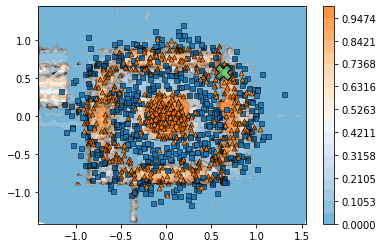

<Figure size 432x288 with 0 Axes>

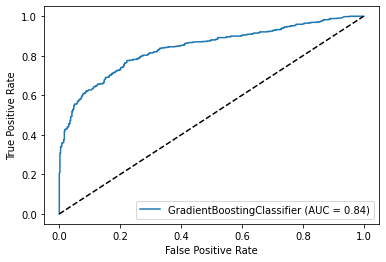

In [21]:
my_plot_decision_regions(gbc, X_test, y_test, event5=True)
my_plot_roc_curve(gbc, X_test, y_test)

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rfc = RandomForestClassifier(n_estimators=400)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
print("predict: \n",rfc.predict(X_test[:5]))
print("predict_proba: \n",rfc.predict_proba(X_test[:5]))

predict: 
 [1 1 1 0 1]
predict_proba: 
 [[0.     1.    ]
 [0.2275 0.7725]
 [0.2525 0.7475]
 [0.5525 0.4475]
 [0.31   0.69  ]]


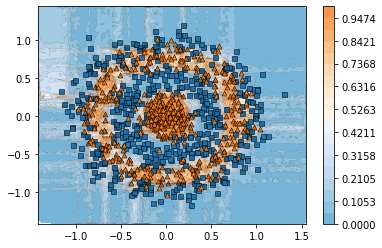

<Figure size 432x288 with 0 Axes>

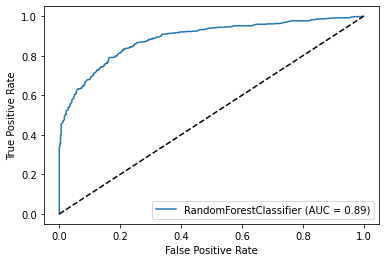

In [25]:
my_plot_decision_regions(rfc, X_test, y_test)
my_plot_roc_curve(rfc, X_test, y_test)

### Comparison

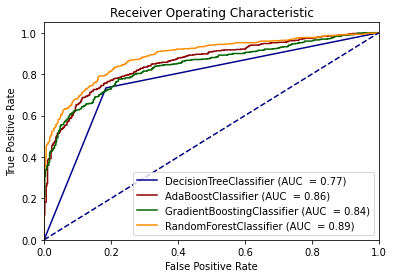

In [26]:
y_preds_dtc = dtc.predict_proba(X_test)[:,1].reshape(-1)
y_preds_abc = abc.predict_proba(X_test)[:,1].reshape(-1)
y_preds_gbc = gbc.predict_proba(X_test)[:,1].reshape(-1)
y_preds_rfc = rfc.predict_proba(X_test)[:,1].reshape(-1)
fpr_dtc,tpr_dtc,_ = roc_curve(y_true=y_test, y_score=y_preds_dtc)
fpr_abc,tpr_abc,_ = roc_curve(y_true=y_test, y_score=y_preds_abc)
fpr_gbc,tpr_gbc,_ = roc_curve(y_true=y_test, y_score=y_preds_gbc)
fpr_rfc,tpr_rfc,_ = roc_curve(y_true=y_test, y_score=y_preds_rfc)
auc_test_dtc = roc_auc_score(y_true=y_test, y_score=y_preds_dtc)
auc_test_abc = roc_auc_score(y_true=y_test, y_score=y_preds_abc)
auc_test_gbc = roc_auc_score(y_true=y_test, y_score=y_preds_gbc)
auc_test_rfc = roc_auc_score(y_true=y_test, y_score=y_preds_rfc)
plt.plot(fpr_dtc, tpr_dtc, color='darkblue',label='{} (AUC  = {})'.format(dtc.__class__.__name__,np.round(auc_test_dtc,decimals=2)))
plt.plot(fpr_abc, tpr_abc, color='darkred',label='{} (AUC  = {})'.format(abc.__class__.__name__,np.round(auc_test_abc,decimals=2)))
plt.plot(fpr_gbc, tpr_gbc, color='darkgreen',label='{} (AUC  = {})'.format(gbc.__class__.__name__,np.round(auc_test_gbc,decimals=2)))
plt.plot(fpr_rfc, tpr_rfc, color='darkorange',label='{} (AUC  = {})'.format(rfc.__class__.__name__,np.round(auc_test_rfc,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right");


### Neural networks
It is possible to use neural networks from scikit-learn (`from sklearn.neural_network import MLPClassifier`). In the following we will use more advanced implementations with [Tensorflow](https://www.tensorflow.org).

In [27]:
try:
  import tensorflow as tf
except ImportError as e:
  !pip install tensorflow
  import tensorflow as tf
print (tf.__version__)  # preinstalled version 2.6.0 20210824
from tensorflow import keras

2.6.0


In [28]:
model = keras.models.Sequential(
    [
     keras.layers.Dense(128, activation='relu', input_shape=(2,)),
     keras.layers.Dense(128, activation='relu'),
     keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=1000,
          callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/1000
25/25 [==============================] - 1s 16ms/step - loss: 0.6709 - accuracy: 0.5163 - auc: 0.6857 - val_loss: 0.6652 - val_accuracy: 0.5400 - val_auc: 0.7548
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6513 - auc: 0.7343 - val_loss: 0.6516 - val_accuracy: 0.7050 - val_auc: 0.7498
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.7538 - auc: 0.7342 - val_loss: 0.6357 - val_accuracy: 0.7600 - val_auc: 0.7512
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.7500 - auc: 0.7388 - val_loss: 0.6160 - val_accuracy: 0.7550 - val_auc: 0.7485
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.7275 - auc: 0.7414 - val_loss: 0.5936 - val_accuracy: 0.7200 - val_auc: 0.7465
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5886 - accuracy: 0.6787 - auc: 0.7403 - val_loss: 0.5

In [30]:
print("predict: \n",model.predict(X_test[:5]))
accuracy_score(y_test, model.predict(X_test).round())

predict: 
 [[0.99993485]
 [0.70130587]
 [0.43711054]
 [0.48231953]
 [0.6060859 ]]


0.833

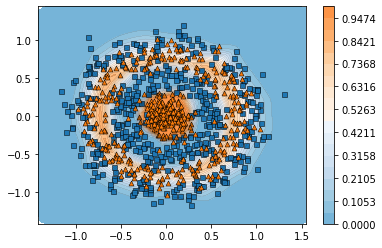

<Figure size 432x288 with 0 Axes>

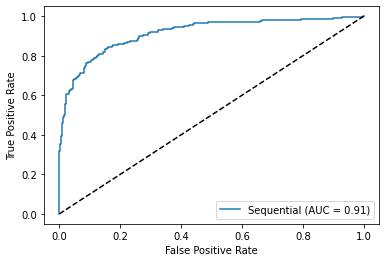

In [31]:
my_plot_decision_regions(model, X_test, y_test)
my_plot_roc_curve(model, X_test, y_test)

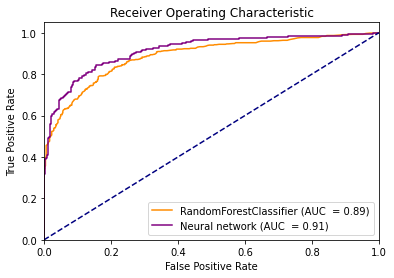

In [32]:
y_preds_model = model.predict(X_test)
fpr_model,tpr_model,_ = roc_curve(y_true=y_test, y_score=y_preds_model)
auc_test_model = roc_auc_score(y_true=y_test, y_score=y_preds_model)
plt.plot(fpr_rfc, tpr_rfc, color='darkorange',label='{} (AUC  = {})'.format(rfc.__class__.__name__,np.round(auc_test_rfc,decimals=2)))
plt.plot(fpr_model, tpr_model, color='purple',label='{} (AUC  = {})'.format("Neural network",np.round(auc_test_model,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right");


# High energy physics application

## Input dataset

Data created from ATLAS Open Data by David Rousseau. See doc:

http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html

### Downloading dataset

In [33]:
import os
filename="dataWW_d1_600k.csv.gz"
if not os.path.isfile(filename):
  try:
    import gdown
  except ImportError as e:
    !pip install gdown
    import gdown
  !gdown https://drive.google.com/uc?id=1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4
!ls -lrt

# Loading dataset
dfall = pd.read_csv(filename) 
print ("\nFile loaded with ",dfall.shape[0], " events ")


total 35136
drwxr-xr-x 1 root root     4096 Aug 25 13:35 sample_data
-rw-r--r-- 1 root root 35905611 Sep  1 07:35 dataWW_d1_600k.csv.gz
-rw-r--r-- 1 root root    37008 Sep  1 09:33 NNmodel.h5
-rw-r--r-- 1 root root     1163 Sep  1 09:33 NNmodel.json
-rw-r--r-- 1 root root    16288 Sep  1 09:33 NNmodel_weights.h5
drwxr-xr-x 4 root root     4096 Sep  1 09:50 NNmodel

File loaded with  600000  events 


After downloading message and directory listing, you should now see:

`File loaded with  600000  events`

### Checking the content

In [34]:
#dumping list of features
dfall.columns

Index(['eventNumber', 'label', 'met_et', 'met_phi', 'lep_n', 'lep_pt_0',
       'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1',
       'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1', 'lep_type_0',
       'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1', 'jet_eta_0', 'jet_eta_1',
       'jet_phi_0', 'jet_phi_1', 'jet_E_0', 'jet_E_1', 'mcWeight', 'runNumber',
       'channelNumber'],
      dtype='object')

In [35]:
#examining first few events
display(dfall.head())

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,249632,1,25.118,1.14010,2,46.439,44.589,0.131030,0.40654,2.34760,-2.41510,46838.0,48325.0,1,-1,13,11,1,53.680,-7.000,2.4346,-7.00000,-0.76667,-7.00000,308720.0,-7.0,0.000002,284500,345323
1,892975,1,27.974,0.84442,2,86.819,55.438,-0.017265,-0.16338,-1.44520,-1.72950,86832.0,56179.0,1,-1,11,13,1,126.700,-7.000,-1.2789,-7.00000,1.66290,-7.00000,245670.0,-7.0,0.000002,284500,345323
2,730573,0,123.290,-2.94810,2,105.810,40.506,-1.338900,-1.03500,0.68539,-0.90527,215700.0,64211.0,1,-1,13,13,0,-7.000,-7.000,-7.0000,-7.00000,-7.00000,-7.00000,-7.0,-7.0,0.002468,284500,363492
3,717584,0,78.558,1.04450,2,56.666,35.124,2.294600,1.88700,2.13110,-2.83820,283930.0,118570.0,-1,1,11,11,2,79.799,53.942,1.6270,0.55314,-1.84880,-0.47055,211610.0,63629.0,0.000197,284500,363492
4,319020,0,15.863,0.74840,2,94.708,72.811,0.812740,0.77954,1.84940,0.45967,127750.0,96077.0,-1,1,11,11,1,143.180,-7.000,-0.6358,-7.00000,-1.91230,-7.00000,173810.0,-7.0,0.000197,284500,363492


In [36]:
#examining feature distributions
dfall.describe()

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
count,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.0,600000.000000
mean,7.029775e+05,0.666667,60.365356,-0.008556,2.005748,60.270328,28.133970,0.000269,-0.000664,0.005219,0.008524,1.164008e+05,5.630948e+04,-0.027027,0.027037,11.907273,11.958010,1.334185,59.606114,13.521164,-1.934521,-4.402337,-1.939645,-4.401941,1.375410e+05,4.125468e+04,0.000218,284500.0,351379.666667
std,4.568961e+05,0.471405,48.153210,1.812778,0.076061,42.676858,20.352272,1.210614,1.235890,1.811177,1.814205,1.083341e+05,5.748834e+04,0.999636,0.999635,0.995692,0.999119,1.232632,79.586143,38.074439,3.349404,3.491304,3.489197,3.559421,1.980717e+05,8.990068e+04,0.000736,0.0,8564.720183
min,1.000000e+00,0.000000,0.044211,-3.141600,2.000000,25.000000,7.000300,-2.700000,-2.699900,-3.141600,-3.141600,2.501300e+04,7.003800e+03,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,-0.045557,284500.0,345323.000000
25%,3.498568e+05,0.000000,33.196000,-1.577600,2.000000,36.624750,15.316000,-0.899650,-0.946043,-1.560200,-1.562900,5.221675e+04,2.329100e+04,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,0.000002,284500.0,345323.000000
50%,6.678815e+05,1.000000,50.082000,-0.018694,2.000000,48.229500,23.644000,0.003413,0.002974,0.014583,0.018823,8.184450e+04,3.824900e+04,-1.000000,1.000000,11.000000,11.000000,1.000000,38.744000,-7.000000,-0.891010,-7.000000,-1.210600,-7.000000,7.501700e+04,-7.000000e+00,0.000029,284500.0,345324.000000
75%,1.001273e+06,1.000000,73.032250,1.559300,2.000000,68.979000,34.149000,0.901950,0.942210,1.573000,1.577300,1.412400e+05,6.730825e+04,1.000000,1.000000,13.000000,13.000000,2.000000,84.291250,26.881000,0.724705,-0.821005,0.967753,-1.088575,1.766200e+05,5.060500e+04,0.000197,284500.0,363492.000000
max,1.997995e+06,1.000000,7062.200000,3.141600,5.000000,7041.400000,744.900000,2.699800,2.700000,3.141500,3.141600,7.041600e+06,2.107900e+06,1.000000,1.000000,13.000000,13.000000,13.000000,1658.200000,1429.800000,2.500000,2.500000,3.141600,3.141600,5.638800e+06,2.784300e+06,0.052420,284500.0,363492.000000


***Event weights***

In [37]:
label_nevents = (dfall[dfall.label==0].shape[0], dfall[dfall.label==1].shape[0] )
print("Number of events per class (B, S):",label_nevents)

label_weights = (dfall[dfall.label==0].mcWeight.sum(), dfall[dfall.label==1].mcWeight.sum() ) 
print("Total weight per class (B, S):    ",label_weights)

Number of events per class (B, S): (200000, 400000)
Total weight per class (B, S):     (124.66229446419997, 6.200053397600001)


## Event selection

Only keep events with exactly two leptons for this exercise.

Only keep events with positive weight, as many ML tools choke on negative weight.

*Note: This is in principle WRONG, only valid if your positive and negative weight events are statistically similar (could then also take the absolute value of the weight to increase statistics).*


In [38]:
print ("Df shape before selection:", dfall.shape)

fulldata=dfall[ (dfall.lep_n==2) & (dfall.mcWeight > 0)]  

print ("Df shape after selection: ",fulldata.shape)

Df shape before selection: (600000, 29)
Df shape after selection:  (577357, 29)


In [39]:
# Hide label and weights in separate vectors (not discriminating features)
# WARNING : there should be neither selection nor shuffling later on! (otherwise misalignement)
target = fulldata["label"]
weights = fulldata["mcWeight"]

# for simplicity only keep some features
# this is actually making a deep copy from fulldata
data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1'])
#data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1']

print ("Df shape of dataset to be used:",data.shape)

Df shape of dataset to be used: (577357, 6)


### Event weights

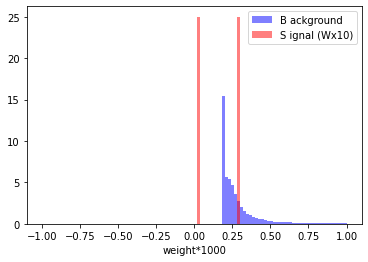

In [40]:
fig,ax=plt.subplots()

bins=np.linspace(-1,1,101)
plt.hist(weights[target==0]*1000,bins=bins,color='b',alpha=0.5,density=True,label='B ackground')
plt.hist(weights[target==1]*10000,bins=bins,color='r',alpha=0.5,density=True,label='S ignal (Wx10)')
plt.legend(loc='best')
ax.set_xlabel('weight*1000')
plt.show()

### Feature engineering

Add more complex variables to the dataset.

*Do this later if time permits.*

In [41]:
if False: 
    data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

    print (data.shape)
    display(data.head())



### Plotting variables

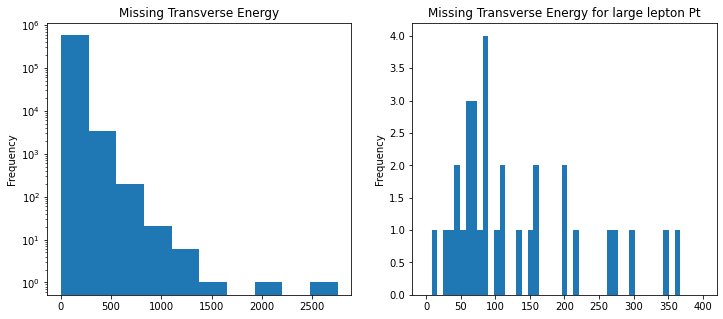

In [42]:
fig,ax=plt.subplots(1, 2, figsize=(12, 5))
data['met_et'].plot.hist(title='Missing Transverse Energy', log=True, ax=ax[0])
data[data.lep_pt_0+data.lep_pt_1>1000]['met_et'].plot.hist(bins=np.linspace(0,400,50),title='Missing Transverse Energy for large lepton Pt', ax=ax[1]);

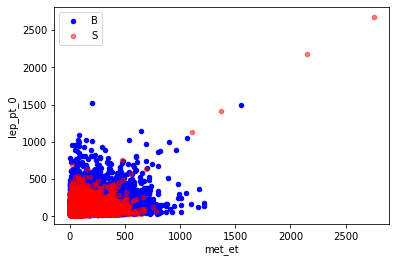

In [43]:
ax=data[target==0].plot.scatter(x='met_et', y='lep_pt_0',color="b",label="B")
data[target==1].plot.scatter(x='met_et', y='lep_pt_0',color="r",label="S",alpha=.5,ax=ax);

In [44]:
data[data.lep_pt_0+data.lep_pt_1>2000].head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
191279,2755.4,1.8538,2678.7,42.131,-1.2958,0.13151
219617,2145.7,0.3056,2180.0,30.531,-2.8257,1.50800


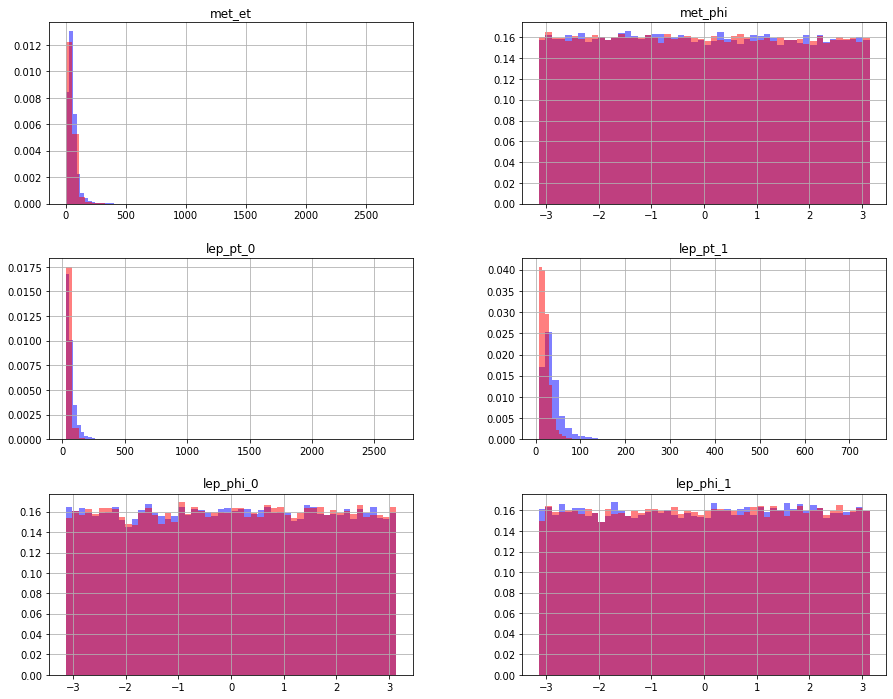

In [45]:
ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),bins=50,color='b',alpha=0.5,density=True,label="B")
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),bins=50,color='r',alpha=0.5,density=True,ax=ax,label="S");


### Features correlation matrix

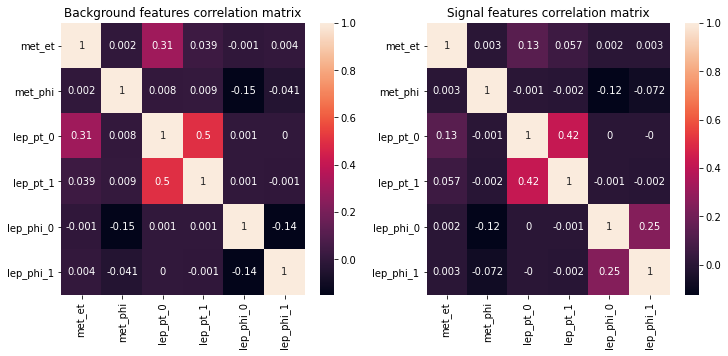

In [46]:
fig,ax=plt.subplots(1, 2, figsize=(12, 5))

corrMatrix = data[target==0].corr()
ax[0].set_title("Background features correlation matrix")
sns.heatmap(corrMatrix.round(3), ax=ax[0], annot=True);

corrMatrix = data[target==1].corr()
ax[1].set_title("Signal features correlation matrix")
sns.heatmap(corrMatrix.round(3), ax=ax[1], annot=True);


## Sample splitting

In [106]:
np.random.seed(31415) # set the random seed (used for the train/test splitting)

from sklearn.model_selection import train_test_split
train_size = 0.75 # fraction of sample used for training
val_size = 0.2 # fraction of training sample used for validation

# split only train/test
#X_train, X_test, y_train, y_test, weights_train, weights_test = \
#    train_test_split(data, target, weights, train_size=train_size)

#split in train/validation/test
X_holdout, X_test, y_holdout, y_test, weights_holdout, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)
X_train, X_val, y_train, y_val, weights_train, weights_val = \
    train_test_split(X_holdout, y_holdout, weights_holdout, train_size=1-val_size)

print("Training sample:  ", X_train.shape)
print("Validation sample:", X_val.shape)
print("Testing sample:   ", X_test.shape)

class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
print ("class_weights_train (B, S):",class_weights_train)

for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    weights_test[y_test == i] *= 1/(1-train_size) # increase test weight to compensate for sampling
    weights_val[y_val == i] *= 1/val_size/train_size # increase val weight to compensate for samplings
    
print ("Test:  total weight sig", weights_test[y_test == 1].sum())
print ("Test:  total weight bkg", weights_test[y_test == 0].sum())
print ("Train: total weight sig", weights_train[y_train == 1].sum())
print ("Train: total weight bkg", weights_train[y_train == 0].sum())
print ("Val:   total weight sig", weights_val[y_val == 1].sum())
print ("Val:   total weight bkg", weights_val[y_val == 0].sum())



Training sample:   (346413, 6)
Validation sample: (86604, 6)
Testing sample:    (144340, 6)
class_weights_train (B, S): (95.3874372528, 3.707816984000001)
Test:  total weight sig 6.166318648
Test:  total weight bkg 160.27470056999996
Train: total weight sig 95.38743725279997
Train: total weight bkg 95.3874372528
Val:   total weight sig 6.200010690666665
Val:   total weight bkg 161.54919669533334


## Network training

In [48]:
try:
  import tensorflow as tf
except ImportError as e:
  !pip install tensorflow
  import tensorflow as tf
print (tf.__version__)  # preinstalled version 2.6.0 20210824
from tensorflow import keras

2.6.0


In [49]:
tf.random.set_seed(1234) # to have reproducible networks
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # 1st hidden layer
  #tf.keras.layers.Dense(128, activation='relu'), # 2nd hidden layer
  tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              #metrics=['accuracy', keras.metrics.AUC(name="auc")]) # if not using event weights
              weighted_metrics=['accuracy', keras.metrics.AUC(name="auc")])

history = model.fit(X_train, y_train.values,
                    epochs=1,
                    #validation_split=0.2,   # to be used with train/test split
                    validation_data=(X_val, y_val, weights_val),
                    batch_size=1024,
                    sample_weight=weights_train.values,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

339/339 [==============================] - 2s 5ms/step - loss: 4.1949e-04 - accuracy: 0.6337 - auc: 0.6804 - val_loss: 9.6483e-04 - val_accuracy: 0.7383 - val_auc: 0.7659


### Standardisation of inputs


In [107]:
from sklearn.preprocessing import StandardScaler

print("Original mean and variance:")
for feature, mean, std in zip(data.columns,X_train.mean(0), X_train.std(0)):
  print("{:9}: {:7.4f} +/- {:7.4f}".format(feature,mean,std))

# Standardize features by removing the mean and scaling to unit variance
# in training sample
scaler = StandardScaler()
# ".values[:]" to keep dataframe and not convert to numpy array
X_train.values[:] = scaler.fit_transform(X_train)
# apply to testing/validation sample the transformation calculated on training sample
X_test.values[:] = scaler.transform(X_test)
X_val.values[:] = scaler.transform(X_val)

print("\nStandardised mean and variance:")
for feature, mean, std in zip(data.columns,X_train.mean(0), X_train.std(0)):
  print("{:9}: {:7.4f} +/- {:7.4f}".format(feature,mean,std))

Original mean and variance:
met_et   : 60.5153 +/- 46.7813
met_phi  : -0.0065 +/-  1.8118
lep_pt_0 : 60.0621 +/- 40.9716
lep_pt_1 : 27.8540 +/- 20.1130
lep_phi_0:  0.0054 +/-  1.8110
lep_phi_1:  0.0095 +/-  1.8132

Standardised mean and variance:
met_et   : -0.0000 +/-  1.0000
met_phi  :  0.0000 +/-  1.0000
lep_pt_0 : -0.0000 +/-  1.0000
lep_pt_1 :  0.0000 +/-  1.0000
lep_phi_0: -0.0000 +/-  1.0000
lep_phi_1:  0.0000 +/-  1.0000


In [51]:
tf.random.set_seed(1234) # to have reproducible networks
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)), # 1st hidden layer
  #tf.keras.layers.Dense(128, activation='relu'), # 2nd hidden layer
  tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              #metrics=['accuracy', keras.metrics.AUC(name="auc")]) # if not using event weights
              weighted_metrics=['accuracy', keras.metrics.AUC(name="auc")])

history = model.fit(X_train, y_train.values,
                    epochs=100,
                    #validation_split=0.2,   # to be used with train/test split
                    validation_data=(X_val, y_val, weights_val),
                    batch_size=1024,
                    sample_weight=weights_train.values,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

y_pred_model = model.predict(X_test).reshape(-1)

Epoch 1/100
339/339 [==============================] - 2s 5ms/step - loss: 3.1209e-04 - accuracy: 0.7182 - auc: 0.7812 - val_loss: 0.0010 - val_accuracy: 0.7188 - val_auc: 0.8084
Epoch 2/100
339/339 [==============================] - 1s 3ms/step - loss: 2.8971e-04 - accuracy: 0.7417 - auc: 0.8127 - val_loss: 0.0011 - val_accuracy: 0.7100 - val_auc: 0.8201
Epoch 3/100
339/339 [==============================] - 1s 3ms/step - loss: 2.8232e-04 - accuracy: 0.7513 - auc: 0.8228 - val_loss: 9.7228e-04 - val_accuracy: 0.7394 - val_auc: 0.8305
Epoch 4/100
339/339 [==============================] - 1s 3ms/step - loss: 2.7514e-04 - accuracy: 0.7606 - auc: 0.8322 - val_loss: 9.9836e-04 - val_accuracy: 0.7301 - val_auc: 0.8391
Epoch 5/100
339/339 [==============================] - 1s 3ms/step - loss: 2.6889e-04 - accuracy: 0.7676 - auc: 0.8395 - val_loss: 0.0010 - val_accuracy: 0.7276 - val_auc: 0.8448
Epoch 6/100
339/339 [==============================] - 1s 3ms/step - loss: 2.6423e-04 - accuracy:

*Compare the training loss/accuracy/AUC after epoch 1 with that obtained before standardisation.*

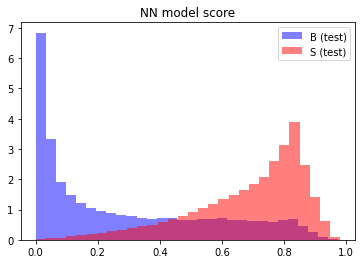

In [52]:
density=True   # normalised to 1 (=> probability density function)
#density=False   # normalised to one year at LHC

plt.hist(y_pred_model[y_test == 0],
         color='b', alpha=0.5, 
         bins=30,
         histtype='stepfilled', density=density,
         label='B (test)', weights=weights_test[y_test == 0])
plt.hist(y_pred_model[y_test == 1],
         color='r', alpha=0.5,
         bins=30,
         histtype='stepfilled', density=density,
         label='S (test)', weights=weights_test[y_test == 1])
plt.legend()
plt.title("NN model score");

<Figure size 432x288 with 0 Axes>

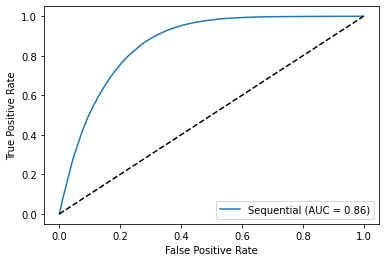

In [53]:
my_plot_roc_curve(model, X_test, y_test)

### Training monitoring

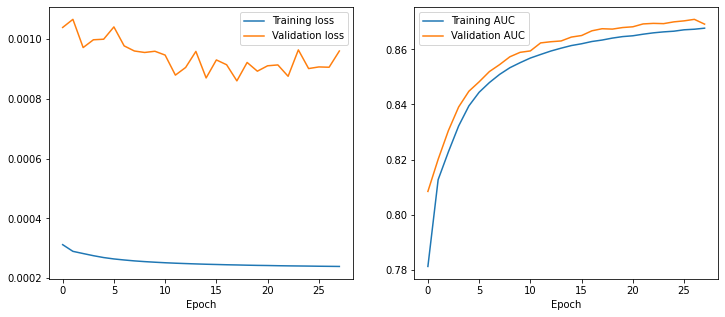

In [54]:
fig,ax=plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(history.history['loss'],label="Training loss")
ax[0].plot(history.history['val_loss'],label="Validation loss")
ax[0].set_xlabel("Epoch")
ax[0].legend(loc='best');

ax[1].plot(history.history['auc'],label="Training AUC")
ax[1].plot(history.history['val_auc'],label="Validation AUC")
ax[1].set_xlabel("Epoch")
ax[1].legend(loc='best');

### Model saving

***Whole-model saving & loading***

You can save an entire model to a directory. It will include:
- the model's architecture/config
- the model's weight values (which were learned during training)
- the model's compilation information (if `compile()` was called)
- the optimizer and its state, if any (this enables you to restart training where you left)


In [55]:
model.save("NNmodel")
!ls -a NNmodel/*

INFO:tensorflow:Assets written to: NNmodel/assets
NNmodel/keras_metadata.pb  NNmodel/saved_model.pb

NNmodel/assets:
.  ..

NNmodel/variables:
.  ..  variables.data-00000-of-00001  variables.index


In [56]:
print("Prediction from original model:")
display(model.predict(X_test[:5]))

reloaded_model=keras.models.load_model("NNmodel")
print("Prediction from reloaded model:")
display(reloaded_model.predict(X_test[:5]))
#np.testing.assert_allclose(
#    model.predict(X_test), reloaded_model.predict(X_test)
#)

# further training
reloaded_model.fit(X_train, y_train.values,
                   epochs=5,
                   #validation_split=0.2,   # to be used with train/test split
                   validation_data=(X_val, y_val, weights_val),
                   batch_size=1024,
                   sample_weight=weights_train.values,
                   callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Prediction from original model:


array([[0.6000348 ],
       [0.22579202],
       [0.7523855 ],
       [0.43202996],
       [0.65642744]], dtype=float32)

Prediction from reloaded model:


array([[0.6000348 ],
       [0.22579202],
       [0.7523855 ],
       [0.43202996],
       [0.65642744]], dtype=float32)

Epoch 1/5
339/339 [==============================] - 3s 6ms/step - loss: 2.4330e-04 - accuracy: 0.7936 - auc: 0.8641 - val_loss: 9.4029e-04 - val_accuracy: 0.7314 - val_auc: 0.8669
Epoch 2/5
339/339 [==============================] - 2s 5ms/step - loss: 2.4278e-04 - accuracy: 0.7941 - auc: 0.8646 - val_loss: 9.3726e-04 - val_accuracy: 0.7296 - val_auc: 0.8677
Epoch 3/5
339/339 [==============================] - 2s 5ms/step - loss: 2.4214e-04 - accuracy: 0.7944 - auc: 0.8652 - val_loss: 8.8020e-04 - val_accuracy: 0.7468 - val_auc: 0.8683
Epoch 4/5
339/339 [==============================] - 2s 5ms/step - loss: 2.4166e-04 - accuracy: 0.7952 - auc: 0.8655 - val_loss: 9.6144e-04 - val_accuracy: 0.7222 - val_auc: 0.8691
Epoch 5/5
339/339 [==============================] - 1s 4ms/step - loss: 2.4115e-04 - accuracy: 0.7954 - auc: 0.8659 - val_loss: 9.1671e-04 - val_accuracy: 0.7363 - val_auc: 0.8694


*Compare first epoch values with original training.*

***Partial save***

Save a single HDF5 file containing the model's architecture, weights values, and `compile()` information.

Not saved (to be provided separately to resume training):
- external losses & metrics added via `model.add_loss()` & `model.add_metric()`
- computation graph of custom objects

In [57]:
model.save("NNmodel.h5")
!ls -lrt --color
print("\nPrediction from original model:")
display(model.predict(X_test[:5]))

reloaded_model=keras.models.load_model("NNmodel.h5")
print("Prediction from reloaded model:")
display(reloaded_model.predict(X_test[:5]))

total 35136
drwxr-xr-x 1 root root     4096 Aug 25 13:35 sample_data
-rw-r--r-- 1 root root 35905611 Sep  1 07:35 dataWW_d1_600k.csv.gz
-rw-r--r-- 1 root root     1163 Sep  1 09:33 NNmodel.json
-rw-r--r-- 1 root root    16288 Sep  1 09:33 NNmodel_weights.h5
drwxr-xr-x 4 root root     4096 Sep  1 15:50 NNmodel
-rw-r--r-- 1 root root    37008 Sep  1 15:51 NNmodel.h5

Prediction from original model:


array([[0.6000348 ],
       [0.22579202],
       [0.7523855 ],
       [0.43202996],
       [0.65642744]], dtype=float32)

Prediction from reloaded model:


array([[0.6000348 ],
       [0.22579202],
       [0.7523855 ],
       [0.43202996],
       [0.65642744]], dtype=float32)

***Saving the architecture and weights***

Keeping the model's configuration and training weights in separate files

In [58]:
arch = model.to_json()
with open('NNmodel.json', 'w') as arch_file:
  arch_file.write(arch)
model.save_weights('NNmodel_weights.h5')
!ls -lrt --color

total 35136
drwxr-xr-x 1 root root     4096 Aug 25 13:35 sample_data
-rw-r--r-- 1 root root 35905611 Sep  1 07:35 dataWW_d1_600k.csv.gz
drwxr-xr-x 4 root root     4096 Sep  1 15:50 NNmodel
-rw-r--r-- 1 root root    37008 Sep  1 15:51 NNmodel.h5
-rw-r--r-- 1 root root     1163 Sep  1 15:51 NNmodel.json
-rw-r--r-- 1 root root    16288 Sep  1 15:51 NNmodel_weights.h5


In [59]:
!python -m json.tool NNmodel.json

{
    "class_name": "Sequential",
    "config": {
        "name": "sequential_2",
        "layers": [
            {
                "class_name": "InputLayer",
                "config": {
                    "batch_input_shape": [
                        null,
                        6
                    ],
                    "dtype": "float32",
                    "sparse": false,
                    "ragged": false,
                    "name": "dense_5_input"
                }
            },
            {
                "class_name": "Dense",
                "config": {
                    "name": "dense_5",
                    "trainable": true,
                    "batch_input_shape": [
                        null,
                        6
                    ],
                    "dtype": "float32",
                    "units": 128,
                    "activation": "relu",
                    "use_bias": true,
                    "kernel_initializer": {
                    

In [65]:
with open('NNmodel.json', 'r') as f:
  reloaded_model = keras.models.model_from_json(f.read())
reloaded_model.summary()

reloaded_model.load_weights("NNmodel_weights.h5")
#reloaded_model.compile(loss="binary_crossentropy",
#                       optimizer="adam",
#                       #metrics=['accuracy', keras.metrics.AUC(name="auc")]) # if not using event weights
#                       weighted_metrics=['accuracy', keras.metrics.AUC(name="auc")])
reloaded_model.fit(X_train, y_train.values,
                    epochs=1,
                    #validation_split=0.2,   # to be used with train/test split
                    validation_data=(X_val, y_val, weights_val),
                    batch_size=1024,
                    sample_weight=weights_train.values,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
339/339 [==============================] - 3s 5ms/step - loss: 2.4330e-04 - accuracy: 0.7936 - auc: 0.8641 - val_loss: 9.4029e-04 - val_accuracy: 0.7314 - val_auc: 0.8669


## Physics performance

### Significance

Asimov significance (from [arXiv:1007.1727](https://arxiv.org/abs/1007.1727) eq. 97):

> AMS = $\sqrt{2\left((s+b)\ln\left(1+\frac{s}{b}\right) - s\right)} = \frac{s}{\sqrt{b}}\left(1+\mathcal{O}(s/b)\right)$

In [69]:
from math import sqrt
from math import log
def amsasimov(s,b):
  if b<=0 or s<=0:
      return 0
  try:
      return sqrt(2*((s+b)*log(1+float(s)/b)-s))
  except ValueError:
      print(1+float(s)/b)
      print (2*((s+b)*log(1+float(s)/b)-s))

In [82]:
int_pred_test_sig_model = [weights_test[(y_test ==1) & (y_pred_model > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_model = [weights_test[(y_test ==0) & (y_pred_model > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_model = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_model,int_pred_test_bkg_model)]
print("Z: ",np.round(max(vamsasimov_model),decimals=3))


Z:  0.803


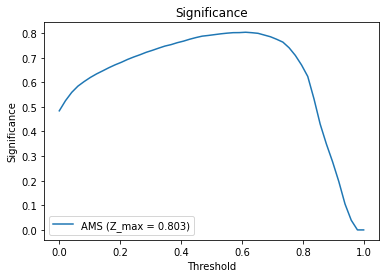

In [71]:
plt.plot(np.linspace(0,1,num=50),vamsasimov_model, label='AMS (Z_max = {})'.format(np.round(max(vamsasimov_model),decimals=3)))

plt.title("Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
#plt.savefig("Significance.pdf")
plt.show()

### Feature importance
Feature importance allows to display the importance of each feature without rerunnning the training. It is obtained from internal algorithm quantities, like cumulated decrease of impurity. Magnitude is arbitrary. It can be used as a not very reliable indication of which feature is the most discriminant.

Very straightforward with decision trees.

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [100]:
gbc = GradientBoostingClassifier(n_estimators=10,verbose=1)
gbc.fit(X_train, y_train, sample_weight=weights_train)

      Iter       Train Loss   Remaining Time 
         1           1.3447           10.24s
         2           1.3104            9.05s
         3           1.2825            7.90s
         4           1.2591            6.72s
         5           1.2392            5.58s
         6           1.2227            4.44s
         7           1.2089            3.32s
         8           1.1971            2.21s
         9           1.1869            1.11s
        10           1.1786            0.00s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

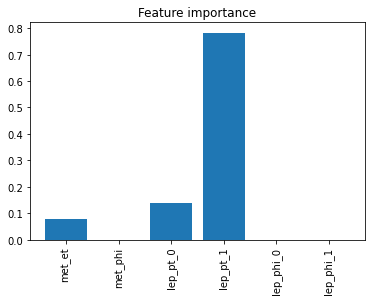

In [101]:
plt.bar(data.columns.values, gbc.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.show()

*What about a different tree classifier?*

In [83]:
# preinstalled version 0.9.0 20210824
!pip install xgboost --upgrade # install 1.4.2 20210824
import xgboost as xgb
print(xgb.__version__)

useLGB=False #Could also use LightGBM
# preinstalled version 2.2.3 20210824
if useLGB:
  !pip install lightgbm --upgrade # install 3.2.1 20210824
  import lightgbm as lgb
  print (lgb.__version__)

1.4.2
3.2.1


In [84]:
from xgboost import XGBClassifier
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss')

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values) # note that XGB 1.3.X requires positive weight



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [85]:
if useLGB:
  gbm = lgb.LGBMClassifier()
  gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)


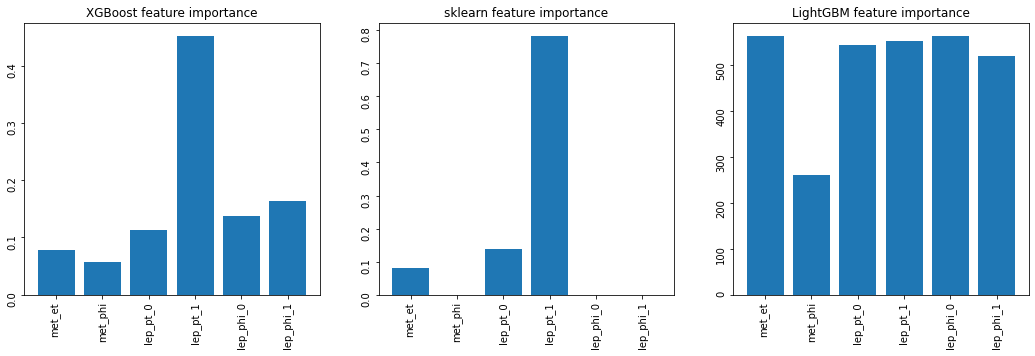

In [102]:
if useLGB:
  fig,ax=plt.subplots(1, 3, figsize=(18, 5))
else:
  fig,ax=plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(data.columns.values, xgb.feature_importances_)
ax[0].tick_params(labelrotation=90)
ax[0].set_title("XGBoost feature importance")
ax[1].bar(data.columns.values, gbc.feature_importances_)
ax[1].tick_params(labelrotation=90)
ax[1].set_title("sklearn feature importance");
if useLGB:
  ax[2].bar(data.columns.values, gbm.feature_importances_)
  ax[2].tick_params(labelrotation=90)
  ax[2].set_title("LightGBM feature importance");


### Permutation importance

A better way to show the importance of each feature is Permutation Importance, where each feature in turn is replaced by an instance of an other event (effectively switching it off by randomising).

Works on any classifier, not just DT-based.

However, report can be misleading in case of highly correlated variables.

Available in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html]) but without event weights in Colab version (0.22).
   


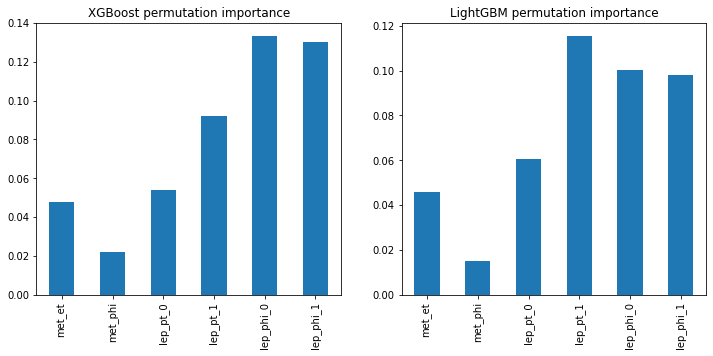

In [112]:
if False:
  from sklearn.inspection import permutation_importance
  result_xgb = permutation_importance(xgb, X_test, y_test, n_repeats=1, random_state=42, n_jobs=2)
  forest_importances_xgb = pd.Series(result_xgb.importances_mean, index=list(data.columns.values))

  if useLGB:
    result_gbm = permutation_importance(gbm, X_test, y_test, n_repeats=1, random_state=42, n_jobs=2)
    forest_importances_gbm = pd.Series(result_gbm.importances_mean, index=list(data.columns.values))

  if useLGB:
    fig,ax=plt.subplots(1, 2, figsize=(12, 5))
    forest_importances_xgb.plot.bar(ax = ax[0], subplots=True)
    ax[0].set_title("XGBoost permutation importance")
  else:
    fig,ax=plt.subplots()
    forest_importances_xgb.plot.bar()
    ax.set_title("XGBoost permutation importance")
  if useLGB:
    forest_importances_gbm.plot.bar(ax = ax[1], subplots=True)
    ax[1].set_title("LightGBM permutation importance")


Another implementation targetting HEP:

https://github.com/aghoshpub/permutationImportancePhysics 

In particular it allows to : 
   * use event weights
   * display directly the loss in whatever criterion (ROC auc, asimov significance) when the feature is switched off
   * display the feature importance for a specific subset (for example the most signal like)
   * it can even display which feature has the largest impact on systematics


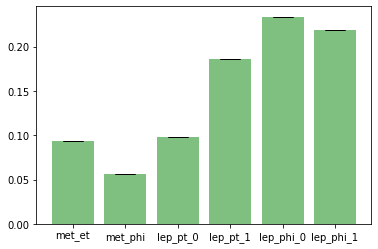

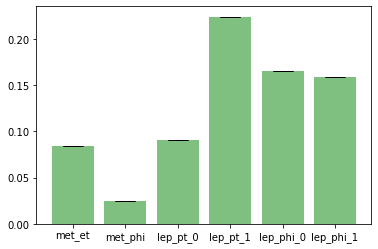

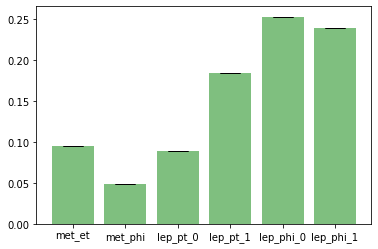

In [113]:
if False:
    !pip install PermutationImportancePhysics
    from permutationimportancephysics.PermutationImportance import PermulationImportance # note the delibrate typo PermuLation
    #XGBoost
    PI_xgb = PermulationImportance(model=xgb, X=X_test.values,y=y_test,weights=weights_test,\
                           n_iterations=1,usePredict_poba=True, scoreFunction="amsasimov", colNames=list(data.columns.values))
    #PI_xgb.dislayResults()
    plott_xgb = PI_xgb.plotBars()

    #LightGBM    
    if useLGB:
      PI_gbm = PermulationImportance(model=gbm, X=X_test.values,y=y_test,weights=weights_test,\
                             n_iterations=1,usePredict_poba=True, scoreFunction="amsasimov", colNames=list(data.columns.values))
      #PI_gbm.dislayResults()
      plott_gbm = PI_gbm.plotBars()

    # also works with Keras NN
    PI_model = PermulationImportance(model=model, X=X_test.values,y=y_test,weights=weights_test,\
                           n_iterations=1,usePredict_poba=False, scoreFunction="amsasimov", colNames=list(data.columns.values))
    #PI_model.dislayResults()
    plott_model = PI_model.plotBars()
    


### Hyperparameter optimisation
Can be done by hand, with [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) or [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Also dedicated packages doing Gaussian process optimisation or 'tree of Parzen estimators' (TPE) (e.g. [hyperopt](https://github.com/hyperopt/hyperop) or [optuna](https://optuna.org/)).

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] learning_rate=0.36356636654033947, n_estimators=271 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.36356636654033947, n_estimators=271, total=   5.7s
[CV] learning_rate=0.36356636654033947, n_estimators=271 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV]  learning_rate=0.36356636654033947, n_estimators=271, total=   5.6s
[CV] learning_rate=0.3259802748251587, n_estimators=274 ..............
[CV]  learning_rate=0.3259802748251587, n_estimators=274, total=   5.7s
[CV] learning_rate=0.3259802748251587, n_estimators=274 ..............
[CV]  learning_rate=0.3259802748251587, n_estimators=274, total=   5.7s
[CV] learning_rate=0.4939743743856536, n_estimators=153 ..............
[CV]  learning_rate=0.4939743743856536, n_estimators=153, total=   3.4s
[CV] learning_rate=0.4939743743856536, n_estimators=153 ..............
[CV]  learning_rate=0.4939743743856536, n_estimators=153, total=   3.3s
[CV] learning_rate=0.3222801903710303, n_estimators=306 ..............
[CV]  learning_rate=0.3222801903710303, n_estimators=306, total=   6.2s
[CV] learning_rate=0.3222801903710303, n_estimators=306 ..............
[CV]  learning_rate=0.3222801903710303, n_estimators=306, total=   6.4s
[CV] learning_rate=0.2760353358226295, n_estimators=334 .............

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   55.9s finished


Best parameters:  {'learning_rate': 0.3222801903710303, 'n_estimators': 306}
Best score (on train dataset CV):  0.8617061044638301
... corresponding score on test dataset:  0.8680326285893968


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,4.628514,0.009615,1.012412,0.010794,0.363566,271,"{'learning_rate': 0.36356636654033947, 'n_esti...",0.861273,0.861823,0.861548,0.000275,2
1,4.675432,0.035864,1.024536,0.022518,0.32598,274,"{'learning_rate': 0.3259802748251587, 'n_estim...",0.860446,0.861551,0.860998,0.000552,4
2,2.751900,0.011826,0.604691,0.000227,0.493974,153,"{'learning_rate': 0.4939743743856536, 'n_estim...",0.858207,0.859722,0.858965,0.000757,5
3,5.181984,0.093391,1.108927,0.008587,0.32228,306,"{'learning_rate': 0.3222801903710303, 'n_estim...",0.861409,0.862003,0.861706,0.000297,1
4,5.708836,0.069213,1.229248,0.022478,0.276035,334,"{'learning_rate': 0.2760353358226295, 'n_estim...",0.861166,0.861681,0.861424,0.000257,3


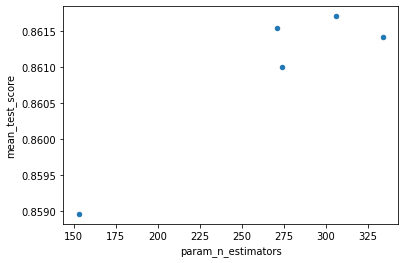

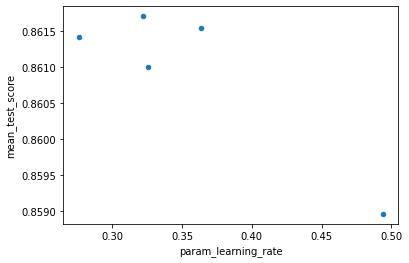

In [99]:
import scipy.stats as stats
if False:
    from sklearn.model_selection import RandomizedSearchCV

    # specify parameters and distributions to sample from
    param_dist_XGB = {'n_estimators': stats.randint(50, 500), #default 100
                      'learning_rate': stats.uniform(0.1, 0.5)} #def 0.3 
                      #'max_depth': stats.randint(3, 12)} # default 6


    # default CV is 5 fold, reduce to 2 for speed concern
    # default n_iter is 10 sets of parameters, reduce to 5 for speed concern
    gsearch = RandomizedSearchCV(estimator = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss'), 
                        param_distributions = param_dist_XGB, 
                        scoring='roc_auc',n_iter=5,cv=2,verbose=2)
    gsearch.fit(X_train,y_train, sample_weight=weights_train)

    print ("Best parameters: ",gsearch.best_params_)
    print ("Best score (on train dataset CV): ",gsearch.best_score_)


    y_pred_gs = gsearch.predict_proba(X_test)[:,1]
    print("... corresponding score on test dataset: ",roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test))
    dfsearch=pd.DataFrame.from_dict(gsearch.cv_results_)
    display(dfsearch)
    dfsearch.plot.scatter("param_n_estimators","mean_test_score")
    #dfsearch.plot.scatter("param_max_depth","mean_test_score")
    dfsearch.plot.scatter("param_learning_rate","mean_test_score")